# Automatic Speech Recognition with Speaker Diarization

In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode

# ## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

## Install TorchAudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html

# Introduction

Speaker diarization lets us figure out "who spoke when" in the transcription. Without speaker diarization, we cannot distinguish the speakers in the transcript generated from automatic speech recognition (ASR). Nowadays, ASR combined with speaker diarization has shown immense use in many tasks, ranging from analyzing meeting transcription to media indexing. 

In this tutorial, we demonstrate how we can get ASR transcriptions combined with speaker labels. Since we don't include a detailed process of getting ASR results or diarization results, please refer to the following links for more in-depth description.

If you need detailed understanding of transcribing words with ASR, refer to this [ASR Tutorial](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/asr/ASR_with_NeMo.ipynb) tutorial.


For detailed parameter setting and execution of speaker diarization, refer to this [Diarization Inference](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/speaker_tasks/Speaker_Diarization_Inference.ipynb) tutorial.


An example script that runs ASR and speaker diarization together can be found at [ASR with Diarization](https://github.com/NVIDIA/NeMo/blob/main/examples/speaker_tasks/diarization/clustering_diarizer/offline_diar_with_asr_infer.py).

### Speaker diarization in ASR pipeline

Speaker diarization results in ASR pipeline should align well with ASR output. Thus, we use ASR output to create Voice Activity Detection (VAD) timestamps to obtain segments we want to diarize. The segments we obtain from the VAD timestamps are further segmented into sub-segments in the speaker diarization step. Finally, after obtaining the speaker labels from speaker diarization, we match the decoded words with speaker labels to generate a transcript with speaker labels.

    ASR → VAD timestamps and decoded words → speaker diarization → speaker label matching

In [2]:
import nemo.collections.asr as nemo_asr
import numpy as np
from IPython.display import Audio, display
import librosa
import os
import wget
import matplotlib.pyplot as plt

import nemo
import glob

import pprint
pp = pprint.PrettyPrinter(indent=4)

/home/taejinp/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(
/home/taejinp/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(
[NeMo W 2022-11-10 16:20:15 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-11-10 16:20:27 nemo_logging:349] /home/taejinp/anaconda3/lib/python3.9/site-packages/torch/jit/annotations.py:296: UserWarning: TorchScript will treat type annotations of Tensor dtype-specific subtypes as if they are normal Tensors. dtype constraints are not enforced in compilation either.
      warnings.warn("TorchScript will treat type annotations of Tensor "
    


We demonstrate this tutorial using a merged AN4 audioclip. The merged audioclip contains the speech of two speakers (male and female) reading dates in different formats. Run the following script to download the audioclip and play it.

In [3]:
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data')
os.makedirs(data_dir, exist_ok=True)

an4_audio_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.wav"
if not os.path.exists(os.path.join(data_dir,'an4_diarize_test.wav')):
    AUDIO_FILENAME = wget.download(an4_audio_url, data_dir)
else:
    AUDIO_FILENAME = os.path.join(data_dir,'an4_diarize_test.wav')

audio_file_list = glob.glob(f"{data_dir}/*.wav")
print("Input audio file list: \n", audio_file_list)

signal, sample_rate = librosa.load(AUDIO_FILENAME, sr=None)
display(Audio(signal,rate=sample_rate))

Input audio file list: 
 ['/home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/an4_diarize_test.wav']


`display_waveform()` and `get_color()` functions are defined for displaying the waveform with diarization results.

In [4]:
def display_waveform(signal,text='Audio',overlay_color=[]):
    fig,ax = plt.subplots(1,1)
    fig.set_figwidth(20)
    fig.set_figheight(2)
    plt.scatter(np.arange(len(signal)),signal,s=1,marker='o',c='k')
    if len(overlay_color):
        plt.scatter(np.arange(len(signal)),signal,s=1,marker='o',c=overlay_color)
    fig.suptitle(text, fontsize=16)
    plt.xlabel('time (secs)', fontsize=18)
    plt.ylabel('signal strength', fontsize=14);
    plt.axis([0,len(signal),-0.5,+0.5])
    time_axis,_ = plt.xticks();
    plt.xticks(time_axis[:-1],time_axis[:-1]/sample_rate);
    
COLORS="b g c m y".split()

def get_color(signal,speech_labels,sample_rate=16000):
    c=np.array(['k']*len(signal))
    for time_stamp in speech_labels:
        start,end,label=time_stamp.split()
        start,end = int(float(start)*16000),int(float(end)*16000),
        if label == "speech":
            code = 'red'
        else:
            code = COLORS[int(label.split('_')[-1])]
        c[start:end]=code
    
    return c 

Using the above function, we can display the waveform of the example audio clip. 

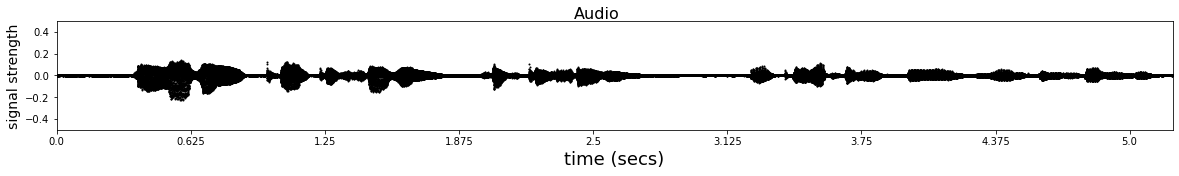

In [5]:
display_waveform(signal)

### Parameter setting for ASR and diarization
First, we need to setup the following parameters for ASR and diarization. We start our demonstration by first transcribing the audio recording using our pretrained ASR model `QuartzNet15x5Base-En` and use the CTC output probabilities to get timestamps for the spoken words. We then use these timestamps to get speaker label information using the speaker diarizer model. 

In [6]:
from omegaconf import OmegaConf
import shutil
DOMAIN_TYPE = "meeting" # Can be meeting or telephonic based on domain type of the audio file
CONFIG_FILE_NAME = f"diar_infer_{DOMAIN_TYPE}.yaml"

CONFIG_URL = f"https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/inference/{CONFIG_FILE_NAME}"

if not os.path.exists(os.path.join(data_dir,CONFIG_FILE_NAME)):
    CONFIG = wget.download(CONFIG_URL, data_dir)
else:
    CONFIG = os.path.join(data_dir,CONFIG_FILE_NAME)

cfg = OmegaConf.load(CONFIG)
print(OmegaConf.to_yaml(cfg))

name: ClusterDiarizer
num_workers: 1
sample_rate: 16000
batch_size: 64
diarizer:
  manifest_filepath: ???
  out_dir: ???
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: vad_multilingual_marblenet
    external_vad_manifest: null
    parameters:
      window_length_in_sec: 0.63
      shift_length_in_sec: 0.01
      smoothing: false
      overlap: 0.5
      onset: 0.9
      offset: 0.5
      pad_onset: 0
      pad_offset: 0
      min_duration_on: 0
      min_duration_off: 0.6
      filter_speech_first: true
  speaker_embeddings:
    model_path: titanet_large
    parameters:
      window_length_in_sec:
      - 3.0
      - 2.5
      - 2.0
      - 1.5
      - 1.0
      - 0.5
      shift_length_in_sec:
      - 1.5
      - 1.25
      - 1.0
      - 0.75
      - 0.5
      - 0.25
      multiscale_weights:
      - 1
      - 1
      - 1
      - 1
      - 1
      - 1
      save_embeddings: true
  clustering:
    parameters:
      oracle_num_speakers: false
      max_

Speaker Diarization scripts commonly expects following arguments:
1. manifest_filepath : Path to manifest file containing json lines of format: `{"audio_filepath": "/path/to/audio_file", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": null, "rttm_filepath": "/path/to/rttm/file", "uem_filepath"="/path/to/uem/filepath"}`
2. out_dir : directory where outputs and intermediate files are stored. 
3. oracle_vad: If this is true then we extract speech activity labels from rttm files, if False then either 
4. vad.model_path or external_manifestpath containing speech activity labels has to be passed. 

Mandatory fields are `audio_filepath`, `offset`, `duration`, `label` and `text`. For the rest if you would like to evaluate with a known number of speakers pass the value else `null`. If you would like to score the system with known rttms then that should be passed as well, else `null`. uem file is used to score only part of your audio for evaluation purposes, hence pass if you would like to evaluate on it else `null`.


**Note:** we expect audio and corresponding RTTM to have **same base name** and the name should be **unique**. 

For example: if audio file name is **test_an4**.wav, if provided we expect corresponding rttm file name to be **test_an4**.rttm (note the matching **test_an4** base name)


Lets create a manifest file with the an4 audio and rttm available. If you have more than one file you may also use the script `NeMo/scripts/speaker_tasks/pathfiles_to_diarize_manifest.py` to generate a manifest file from a list of audio files. In addition, you can optionally include rttm files to evaluate the diarization results.

In [7]:
# Create a manifest file for input with below format. 
# {"audio_filepath": "/path/to/audio_file", "offset": 0, "duration": null, "label": "infer", "text": "-", 
# "num_speakers": null, "rttm_filepath": "/path/to/rttm/file", "uem_filepath"="/path/to/uem/filepath"}
import json
meta = {
    'audio_filepath': AUDIO_FILENAME, 
    'offset': 0, 
    'duration':None, 
    'label': 'infer', 
    'text': '-', 
    'num_speakers': None, 
    'rttm_filepath': None, 
    'uem_filepath' : None
}
with open(os.path.join(data_dir,'input_manifest.json'),'w') as fp:
    json.dump(meta,fp)
    fp.write('\n')

cfg.diarizer.manifest_filepath = os.path.join(data_dir,'input_manifest.json')
!cat {cfg.diarizer.manifest_filepath}

{"audio_filepath": "/home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/an4_diarize_test.wav", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": null, "rttm_filepath": null, "uem_filepath": null}


Let's set the parameters required for diarization. In this tutorial, we obtain voice activity labels from ASR, which is set through parameter `cfg.diarizer.asr.parameters.asr_based_vad`.

In [8]:
pretrained_speaker_model='titanet_large'
cfg.diarizer.manifest_filepath = cfg.diarizer.manifest_filepath
cfg.diarizer.out_dir = data_dir #Directory to store intermediate files and prediction outputs
cfg.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
cfg.diarizer.clustering.parameters.oracle_num_speakers=False

# Using Neural VAD and Conformer ASR 
cfg.diarizer.vad.model_path = 'vad_multilingual_marblenet'
cfg.diarizer.asr.model_path = 'stt_en_conformer_ctc_large'
cfg.diarizer.oracle_vad = False # ----> Not using oracle VAD 
cfg.diarizer.asr.parameters.asr_based_vad = False

### Run ASR and get word timestamps
Before we run speaker diarization, we should run ASR and get the ASR output to generate decoded words and timestamps for those words. Let's import `ASRDecoderTimeStamps` class and create `asr_decoder_ts` instance that returns an ASR model. Using this ASR model, the following two variables are obtained from `asr_decoder_ts.run_ASR()` function.

- word_hyp Dict[str, List[str]]: contains the sequence of words.
- word_ts_hyp Dict[str, List[int]]: contains frame level index of the start and the end of each word.

In [9]:
from nemo.collections.asr.parts.utils.decoder_timestamps_utils import ASRDecoderTimeStamps
asr_decoder_ts = ASRDecoderTimeStamps(cfg.diarizer)
asr_model = asr_decoder_ts.set_asr_model()
word_hyp, word_ts_hyp = asr_decoder_ts.run_ASR(asr_model)

print("Decoded word output dictionary: \n", word_hyp['an4_diarize_test'])
print("Word-level timestamps dictionary: \n", word_ts_hyp['an4_diarize_test'])

[NeMo I 2022-11-10 16:20:28 speaker_utils:92] Number of files to diarize: 1
[NeMo I 2022-11-10 16:20:28 cloud:56] Found existing object /home/taejinp/.cache/torch/NeMo/NeMo_1.13.0rc0/stt_en_conformer_ctc_large/afb212c5bcf904e326b5e5751e7c7465/stt_en_conformer_ctc_large.nemo.
[NeMo I 2022-11-10 16:20:28 cloud:62] Re-using file from: /home/taejinp/.cache/torch/NeMo/NeMo_1.13.0rc0/stt_en_conformer_ctc_large/afb212c5bcf904e326b5e5751e7c7465/stt_en_conformer_ctc_large.nemo
[NeMo I 2022-11-10 16:20:28 common:911] Instantiating model from pre-trained checkpoint
[NeMo I 2022-11-10 16:20:29 mixins:170] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2022-11-10 16:20:29 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket1/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket2/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket3/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket4/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket5/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket6/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket7/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 1
    shuffle: true
    num_workers: 4
    pin_memory: true
    use_start_end_token: false
    trim_

[NeMo I 2022-11-10 16:20:29 features:225] PADDING: 0
[NeMo I 2022-11-10 16:20:33 save_restore_connector:243] Model EncDecCTCModelBPE was successfully restored from /home/taejinp/.cache/torch/NeMo/NeMo_1.13.0rc0/stt_en_conformer_ctc_large/afb212c5bcf904e326b5e5751e7c7465/stt_en_conformer_ctc_large.nemo.


[NeMo W 2022-11-10 16:20:33 decoder_timestamps_utils:66] `ctc_decode` was set to True. Note that this is ignored.


[NeMo I 2022-11-10 16:20:33 features:225] PADDING: 0
[NeMo I 2022-11-10 16:20:33 features:225] PADDING: 0
[NeMo I 2022-11-10 16:20:33 decoder_timestamps_utils:640] Running ASR model stt_en_conformer_ctc_large
[NeMo I 2022-11-10 16:20:33 decoder_timestamps_utils:644] [1/1] FrameBatchASR: /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/an4_diarize_test.wav
Decoded word output dictionary: 
 ['eleven', 'twenty', 'seven', 'fifty', 'seven', 'october', 'twenty', 'fourth', 'nineteen', 'seventy']
Word-level timestamps dictionary: 
 [[0.36, 0.68], [0.92, 1.28], [1.4, 1.64], [1.92, 2.28], [2.36, 2.6], [3.08, 3.52], [3.6, 3.84], [3.88, 4.12], [4.4, 4.72], [4.84, 5.16]]


Let's create an instance `asr_diar_offline` from OfflineDiarWithASR class, which matches diarization results with ASR outputs. We pass ``cfg.diarizer`` to setup the parameters for both ASR and diarization. We also set `word_ts_anchor_offset` variable that determines the anchor position of each word. Here, we use the default value from `asr_decoder_ts` instance.

In [10]:
from nemo.collections.asr.parts.utils.diarization_utils import OfflineDiarWithASR
asr_diar_offline = OfflineDiarWithASR(cfg.diarizer)
asr_diar_offline.word_ts_anchor_offset = asr_decoder_ts.word_ts_anchor_offset

[NeMo I 2022-11-10 16:20:35 speaker_utils:92] Number of files to diarize: 1


`asr_diar_offline` instance is now ready. As a next step, we run diarization.

### Run diarization with the extracted word timestamps

Now that all the components for diarization is ready, let's run diarization by calling `run_diarization()` function. `run_diarization()` will return two different variables : `diar_hyp` and `diar_score`. `diar_hyp` is diarization inference result which is written in `[start time] [end time] [speaker]` format. `diar_score` contains `None` since we did not provide `rttm_filepath` in the input manifest file.

In [11]:
diar_hyp, diar_score = asr_diar_offline.run_diarization(cfg, word_ts_hyp)
print("Diarization hypothesis output: \n", diar_hyp['an4_diarize_test'])

[NeMo I 2022-11-10 16:20:35 clustering_diarizer:129] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2022-11-10 16:20:35 cloud:56] Found existing object /home/taejinp/.cache/torch/NeMo/NeMo_1.13.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2022-11-10 16:20:35 cloud:62] Re-using file from: /home/taejinp/.cache/torch/NeMo/NeMo_1.13.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2022-11-10 16:20:35 common:911] Instantiating model from pre-trained checkpoint


[NeMo W 2022-11-10 16:20:35 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2022-11-10 16:20:35 features:225] PADDING: 16
[NeMo I 2022-11-10 16:20:35 save_restore_connector:243] Model EncDecClassificationModel was successfully restored from /home/taejinp/.cache/torch/NeMo/NeMo_1.13.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2022-11-10 16:20:35 clustering_diarizer:156] Loading pretrained titanet_large model from NGC
[NeMo I 2022-11-10 16:20:35 cloud:56] Found existing object /home/taejinp/.cache/torch/NeMo/NeMo_1.13.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-11-10 16:20:35 cloud:62] Re-using file from: /home/taejinp/.cache/torch/NeMo/NeMo_1.13.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-11-10 16:20:35 common:911] Instantiating model from pre-trained checkpoint


[NeMo W 2022-11-10 16:20:36 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-11-10 16:20:36 modelPT:149] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-11-10 16:20:36 label_models:126] Setting angular: true/false in decoder is deprecated and will be removed in 1.13 version, use specific loss with _target_
[NeMo I 2022-11-10 16:20:36 features:225] PADDING: 16
[NeMo I 2022-11-10 16:20:37 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /home/taejinp/.cache/torch/NeMo/NeMo_1.13.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-11-10 16:20:37 speaker_utils:92] Number of files to diarize: 1
[NeMo I 2022-11-10 16:20:37 clustering_diarizer:303] Split long audio file to avoid CUDA memory issue


[NeMo I 2022-11-10 16:20:38 vad_utils:100] The prepared manifest file exists. Overwriting!
[NeMo I 2022-11-10 16:20:38 classification_models:247] Perform streaming frame-level VAD
[NeMo I 2022-11-10 16:20:38 collections:296] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-11-10 16:20:38 collections:300] # 1 files loaded accounting to # 1 labels


[NeMo I 2022-11-10 16:20:38 clustering_diarizer:258] Converting frame level prediction to speech/no-speech segment in start and end times format.


[NeMo I 2022-11-10 16:20:38 clustering_diarizer:281] Subsegmentation for embedding extraction: scale0, /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-11-10 16:20:38 clustering_diarizer:336] Extracting embeddings for Diarization
[NeMo I 2022-11-10 16:20:38 collections:296] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-11-10 16:20:38 collections:300] # 3 files loaded accounting to # 1 labels


[NeMo I 2022-11-10 16:20:38 clustering_diarizer:380] Saved embedding files to /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/speaker_outputs/embeddings
[NeMo I 2022-11-10 16:20:38 clustering_diarizer:281] Subsegmentation for embedding extraction: scale1, /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/speaker_outputs/subsegments_scale1.json
[NeMo I 2022-11-10 16:20:38 clustering_diarizer:336] Extracting embeddings for Diarization
[NeMo I 2022-11-10 16:20:38 collections:296] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-11-10 16:20:38 collections:300] # 4 files loaded accounting to # 1 labels


[NeMo I 2022-11-10 16:20:39 clustering_diarizer:380] Saved embedding files to /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/speaker_outputs/embeddings
[NeMo I 2022-11-10 16:20:39 clustering_diarizer:281] Subsegmentation for embedding extraction: scale2, /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/speaker_outputs/subsegments_scale2.json
[NeMo I 2022-11-10 16:20:39 clustering_diarizer:336] Extracting embeddings for Diarization
[NeMo I 2022-11-10 16:20:39 collections:296] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-11-10 16:20:39 collections:300] # 5 files loaded accounting to # 1 labels


[NeMo I 2022-11-10 16:20:39 clustering_diarizer:380] Saved embedding files to /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/speaker_outputs/embeddings
[NeMo I 2022-11-10 16:20:39 clustering_diarizer:281] Subsegmentation for embedding extraction: scale3, /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/speaker_outputs/subsegments_scale3.json
[NeMo I 2022-11-10 16:20:39 clustering_diarizer:336] Extracting embeddings for Diarization
[NeMo I 2022-11-10 16:20:39 collections:296] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-11-10 16:20:39 collections:300] # 6 files loaded accounting to # 1 labels


[NeMo I 2022-11-10 16:20:39 clustering_diarizer:380] Saved embedding files to /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/speaker_outputs/embeddings
[NeMo I 2022-11-10 16:20:39 clustering_diarizer:281] Subsegmentation for embedding extraction: scale4, /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/speaker_outputs/subsegments_scale4.json
[NeMo I 2022-11-10 16:20:39 clustering_diarizer:336] Extracting embeddings for Diarization
[NeMo I 2022-11-10 16:20:39 collections:296] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-11-10 16:20:39 collections:300] # 10 files loaded accounting to # 1 labels


[NeMo I 2022-11-10 16:20:39 clustering_diarizer:380] Saved embedding files to /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/speaker_outputs/embeddings
[NeMo I 2022-11-10 16:20:39 clustering_diarizer:281] Subsegmentation for embedding extraction: scale5, /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/speaker_outputs/subsegments_scale5.json
[NeMo I 2022-11-10 16:20:39 clustering_diarizer:336] Extracting embeddings for Diarization
[NeMo I 2022-11-10 16:20:39 collections:296] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-11-10 16:20:39 collections:300] # 20 files loaded accounting to # 1 labels


[NeMo I 2022-11-10 16:20:40 clustering_diarizer:380] Saved embedding files to /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/speaker_outputs/embeddings


[NeMo W 2022-11-10 16:20:42 der:105] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2022-11-10 16:20:42 clustering_diarizer:455] Outputs are saved in /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data directory
Diarization hypothesis output: 
 ['0.07 2.695 speaker_0', '2.695 5.199999999999999 speaker_1']


`run_diarization()` function also creates `an4_diarize_test.rttm` file. Let's check what is written in this `rttm` file.

[   'SPEAKER an4_diarize_test 1   0.070   2.625 <NA> <NA> speaker_0 <NA> <NA>',
    'SPEAKER an4_diarize_test 1   2.695   2.505 <NA> <NA> speaker_1 <NA> <NA>']


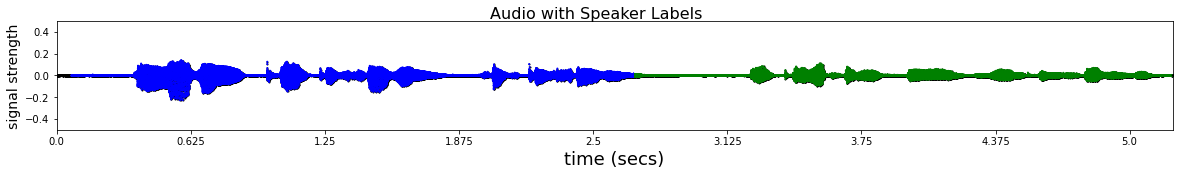

In [12]:
def read_file(path_to_file):
    with open(path_to_file) as f:
        contents = f.read().splitlines()
    return contents

predicted_speaker_label_rttm_path = f"{data_dir}/pred_rttms/an4_diarize_test.rttm"
pred_rttm = read_file(predicted_speaker_label_rttm_path)

pp.pprint(pred_rttm)

from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels
pred_labels = rttm_to_labels(predicted_speaker_label_rttm_path)

color = get_color(signal, pred_labels)
display_waveform(signal,'Audio with Speaker Labels', color)
display(Audio(signal,rate=16000))

### Check the speaker-labeled ASR transcription output

Now we've done all the processes for running ASR and diarization, let's match the diarization result with the ASR result and get the final output. `get_transcript_with_speaker_labels()` function in `asr_diar_offline` matches diarization output `diar_hyp` with `word_hyp` using the timestamp information from `word_ts_hyp`. 

In [13]:
trans_info_dict = asr_diar_offline.get_transcript_with_speaker_labels(diar_hyp, word_hyp, word_ts_hyp)

[NeMo I 2022-11-10 16:20:43 diarization_utils:787] Creating results for Session: an4_diarize_test n_spk: 2 
[NeMo I 2022-11-10 16:20:43 diarization_utils:660] Diarization with ASR output files are saved in: /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/pred_rttms


After running `get_transcript_with_speaker_labels()` function, the transcription output will be located in `./pred_rttms` folder, which shows **start time to end time of the utterance, speaker ID, and words spoken** during the notified time.

In [14]:
transcription_path_to_file = f"{data_dir}/pred_rttms/an4_diarize_test.txt"
transcript = read_file(transcription_path_to_file)
pp.pprint(transcript)

[   '[00:00.07 - 00:02.60] speaker_0: eleven twenty seven fifty seven',
    '[00:03.08 - 00:05.16] speaker_1: october twenty fourth nineteen seventy']


Another output is transcription output in JSON format, which is saved in `./pred_rttms/an4_diarize_test.json`. 

In the JSON format output, we include information such as **transcription, estimated number of speakers (variable named `speaker_count`), start and end time of each word and most importantly, speaker label for each word.**

In [15]:
transcription_path_to_file = f"{data_dir}/pred_rttms/an4_diarize_test.json"
json_contents = read_file(transcription_path_to_file)
pp.pprint(json_contents)

[   '{',
    '    "status": "success",',
    '    "session_id": "an4_diarize_test",',
    '    "transcription": "eleven twenty seven fifty seven october twenty '
    'fourth nineteen seventy",',
    '    "speaker_count": 2,',
    '    "words": [',
    '        {',
    '            "word": "eleven",',
    '            "start_time": 0.36,',
    '            "end_time": 0.68,',
    '            "speaker": "speaker_0"',
    '        },',
    '        {',
    '            "word": "twenty",',
    '            "start_time": 0.92,',
    '            "end_time": 1.28,',
    '            "speaker": "speaker_0"',
    '        },',
    '        {',
    '            "word": "seven",',
    '            "start_time": 1.4,',
    '            "end_time": 1.64,',
    '            "speaker": "speaker_0"',
    '        },',
    '        {',
    '            "word": "fifty",',
    '            "start_time": 1.92,',
    '            "end_time": 2.28,',
    '            "speaker": "speaker_0"',
    '        

### Evaluation of Speaker Diarization with ASR (Multi-speaker ASR)

When it comes to ASR, we use word error rate (WER) to measure the accuracy of an ASR model's performance on speech to text (STT) tasks. For speaker diarization, we use diarization error rate (DER), but DER does not include the accuracy of the ASR system. 

To overcome such limitations, concatenated minimum-permutation word error rate (**cpWER**) is proposed as a new scoring method which can evaluate speaker diarization and speech recognition performance at the same time.

cpWER is calculated by going through the following steps.

1. Concatenate all utterances of each speaker for both reference and hypothesis files.
2. Compute the WER between the reference and all possible speaker permutations of the hypothesis.
3. Pick the lowest WER among them (this is assumed to be the best permutation.

cpWER was proposed in [this article](https://arxiv.org/pdf/2004.09249.pdf) about CHiME-6 Challenge.

For our example file `an4_diarize_test.wav`, we pick the lowest WER value from the two permutations as follows:

In [16]:
hyp1 = "eleven twenty seven fifty seven october twenty fourth nineteen seventy"
hyp2 = "october twenty fourth nineteen seventy eleven twenty seven fifty seven"

#### Session-by-session evaluation with a CTM file

To calculate cpWER value, we need to prepare word sequence lists and CTM files. The word sequence list can be obtained from the `trans_info_dict` variable that is obtained from the function named `get_transcript_with_speaker_labels`.

Each word in a word sequence list should be annotated as in the following example.
```
{'word': 'hello', 
'start_time': 12.2, 
'end_time': 12.54, 
'speaker_label': 'speaker_0'}
```

In [17]:
from nemo.collections.asr.parts.utils.speaker_utils import get_uniqname_from_filepath

word_seq_lists = []
uniq_id = "an4_diarize_test"

# Add the list in `trans_info_dict[uniq_id]['words']`.
word_seq_lists.append(trans_info_dict[uniq_id]['words'])

# Print the first session in `word_seq_lists`.
print("word_seq_lists:\n", word_seq_lists[0])

word_seq_lists:
 [{'word': 'eleven', 'start_time': 0.36, 'end_time': 0.68, 'speaker': 'speaker_0'}, {'word': 'twenty', 'start_time': 0.92, 'end_time': 1.28, 'speaker': 'speaker_0'}, {'word': 'seven', 'start_time': 1.4, 'end_time': 1.64, 'speaker': 'speaker_0'}, {'word': 'fifty', 'start_time': 1.92, 'end_time': 2.28, 'speaker': 'speaker_0'}, {'word': 'seven', 'start_time': 2.36, 'end_time': 2.6, 'speaker': 'speaker_0'}, {'word': 'october', 'start_time': 3.08, 'end_time': 3.52, 'speaker': 'speaker_1'}, {'word': 'twenty', 'start_time': 3.6, 'end_time': 3.84, 'speaker': 'speaker_1'}, {'word': 'fourth', 'start_time': 3.88, 'end_time': 4.12, 'speaker': 'speaker_1'}, {'word': 'nineteen', 'start_time': 4.4, 'end_time': 4.72, 'speaker': 'speaker_1'}, {'word': 'seventy', 'start_time': 4.84, 'end_time': 5.16, 'speaker': 'speaker_1'}]


We also need CTM files as reference transcripts. The columns of a CTM file indicate the following items:

`<session name> <channel ID> <start time> <duration> <word> <confidence>`
- Example:
`diar_session_123 speaker_3 13.2 0.25 hi 0`

For the purpose of creating the reference annotations, we use `<channel ID>` for speaker labels and assign 0 to `<confidence>`. The reference CTM file for the `an4_diarize_test.wav` looks like the following:

In [18]:
an4_diarize_test_ctm = \
["an4_diarize_test speaker_0 0.4 0.51 eleven 0",
"an4_diarize_test speaker_0 0.95 0.32 twenty 0",
"an4_diarize_test speaker_0 1.35 0.55 seven 0",
"an4_diarize_test speaker_0 1.96 0.32 fifty 0",
"an4_diarize_test speaker_0 2.32 0.75 seven 0",
"an4_diarize_test speaker_1 3.12 0.42 october 0",
"an4_diarize_test speaker_1 3.6 0.28 twenty 0",
"an4_diarize_test speaker_1 3.95 0.35 fourth 0",
"an4_diarize_test speaker_1 4.3 0.31 nineteen 0",
"an4_diarize_test speaker_1 4.65 0.35 seventy 0"]

**Caveat:** Note that the original order of the words should NOT be permuted in the reference CTM file. 

In [19]:
def write_ctm(path, the_list): 
    outF = open(path, "w")
    for line in the_list:
        outF.write(line)
        outF.write("\n")
    outF.close()
    
write_ctm(f"{data_dir}/an4_diarize_test.ctm", an4_diarize_test_ctm)

As opposed to cpWER, we refer to the standard WER value as `WER` since the channels or speakers are mixed in one channel (speaker) when the WER value is calculated. Thus, `WER` is calculated by comparing the sequentially ordered hypothesis words with the reference CTM file.
Calculate `cpWER` and `WER` by feeding `word_seq_lists` and `ctm_file_list` to a function named `calculate_cpWER`. 

In [20]:
from nemo.collections.asr.metrics.der import concat_perm_word_error_rate
from nemo.collections.asr.metrics.wer import word_error_rate
from nemo.collections.asr.parts.utils.diarization_utils import convert_word_dict_seq_to_text, convert_ctm_to_text
# Provide a list containing the paths to the reference CTM files 
# which have the same order with filenames in word_seq_lists.

word_seq_list = trans_info_dict['an4_diarize_test']['words']
ctm_file_path = f"{data_dir}/an4_diarize_test.ctm"

spk_hypothesis, mix_hypothesis = convert_word_dict_seq_to_text(word_seq_list)
spk_reference, mix_reference = convert_ctm_to_text(ctm_file_path)

print(f"spk_hypothesis: {spk_hypothesis}")
print(f"mix_hypothesis: {mix_hypothesis}\n")
print(f"spk_reference: {spk_reference}")
print(f"mix_reference: {mix_reference}")

spk_hypothesis: ['eleven twenty seven fifty seven', 'october twenty fourth nineteen seventy']
mix_hypothesis: eleven twenty seven fifty seven october twenty fourth nineteen seventy

spk_reference: ['eleven twenty seven fifty seven', 'october twenty fourth nineteen seventy']
mix_reference: eleven twenty seven fifty seven october twenty fourth nineteen seventy


As you can see from thee above examples, we need to prepare speaker-separated transcriptions to calculate cpWER.

Now that we prepared the necessary inputs for calculating WER and cpWER, lets feed the input data into `concat_perm_word_error_rate` function and `word_error_rate` function. Please note that these two functions accept list as an input where multiple utterance(session) are included in the list keeping the orders in the input manifest file.

In [21]:
from nemo.collections.asr.metrics.der import concat_perm_word_error_rate 
from nemo.collections.asr.metrics.wer import word_error_rate

cpWER, concat_hyp, concat_ref = concat_perm_word_error_rate([spk_hypothesis], [spk_reference])
WER = word_error_rate([mix_hypothesis], [mix_reference])

print(f"cpWER: {cpWER[0]}")
print(f"WER: {WER}")

# Check the concatenated hypothesis and reference transcript
print(f"concat_hyp: {concat_hyp[0]}")
print(f"concat_ref: {concat_ref[0]}")

cpWER: 0.0
WER: 0.0
concat_hyp: eleven twenty seven fifty seven october twenty fourth nineteen seventy
concat_ref: eleven twenty seven fifty seven october twenty fourth nineteen seventy


Note that `cpWER` and `WER` can be different. For example, if one word is wrongly assigned to the second speaker, cpWER gets one miss error and one insertion error while WER stays the same.

In [22]:
from nemo.collections.asr.parts.utils.diarization_utils import convert_word_dict_seq_to_text

# Let's artificially flip a speaker label and check whether cpWER reflects it
word_seq_lists[0][-1]['speaker_label'] = 'speaker_0'
spk_hypothesis, mix_hypothesis = convert_word_dict_seq_to_text(word_seq_list)


spk_hypothesis, mix_hypothesis = convert_word_dict_seq_to_text(word_seq_list)

# Check that "seventy" in spk_hypothesis has been moved to speaker_0
print(f"spk_hypothesis: {spk_hypothesis}")
print(f"mix_hypothesis: {mix_hypothesis}\n")

print(f"spk_reference: {spk_reference}")
print(f"mix_reference: {mix_reference}")

# Recalculate cpWER and WER
cpWER, concat_hyp, concat_ref = concat_perm_word_error_rate([spk_hypothesis], [spk_reference])
WER = word_error_rate([mix_hypothesis], [mix_reference])

print(f"cpWER: {cpWER[0]}")
print(f"WER: {WER}")

spk_hypothesis: ['eleven twenty seven fifty seven', 'october twenty fourth nineteen seventy']
mix_hypothesis: eleven twenty seven fifty seven october twenty fourth nineteen seventy

spk_reference: ['eleven twenty seven fifty seven', 'october twenty fourth nineteen seventy']
mix_reference: eleven twenty seven fifty seven october twenty fourth nineteen seventy
cpWER: 0.0
WER: 0.0


In the second example where a speaker label is artificially flipped, we can see that `WER` has not been changed while `cpWER` has been changed. This shows that the diarization result is degraded while the ASR result keeps its accuracy.

#### Provide CTM files in the input manifest file for cpWER evaluation

If CTM files are provided in the input manifest file, we can call `calculate_cpWER` function to directly get `cpWER` value for each session. The following lines show how to provide the path of CTM files into a manifest file.

In [23]:
# Create a new manifest file for input with the reference CTM file. 
meta = {
    'audio_filepath': AUDIO_FILENAME, 
    'offset': 0, 
    'duration':None, 
    'label': 'infer', 
    'text': '-', 
    'num_speakers': 2, 
    'rttm_filepath': None,
    'ctm_filepath': f"{data_dir}/an4_diarize_test.ctm",
    'uem_filepath' : None
}

with open(os.path.join(data_dir,'input_manifest.json'),'w') as fp:
    json.dump(meta,fp)
    fp.write('\n')

cfg.diarizer.manifest_filepath = os.path.join(data_dir,'input_manifest.json')
!cat {cfg.diarizer.manifest_filepath}

# We need to call `make_file_lists` again to update manifest file to `asr_diar_offline` instance 
asr_diar_offline.make_file_lists()

{"audio_filepath": "/home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/an4_diarize_test.wav", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": 2, "rttm_filepath": null, "ctm_filepath": "/home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/an4_diarize_test.ctm", "uem_filepath": null}
[NeMo I 2022-11-10 16:20:43 speaker_utils:92] Number of files to diarize: 1


Call `evaluate` function by feeding the `trans_info_dict` variable to calculate 

In [24]:
trans_info_dict = asr_diar_offline.get_transcript_with_speaker_labels(diar_hyp, word_hyp, word_ts_hyp)
session_result_dict = asr_diar_offline.evaluate(trans_info_dict)
session_result_dict['an4_diarize_test']

print("cpWER:", session_result_dict['an4_diarize_test']['cpWER'])
print("WER:", session_result_dict['an4_diarize_test']['WER'])

[NeMo I 2022-11-10 16:20:43 diarization_utils:787] Creating results for Session: an4_diarize_test n_spk: 2 
[NeMo I 2022-11-10 16:20:43 diarization_utils:660] Diarization with ASR output files are saved in: /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/pred_rttms
cpWER: 0.0
WER: 0.0


### Optional Features for ASR with Speaker Diarization

#### Beam search decoder
Beam-search decoder can be applied to CTC based ASR models. To use this feature, [pyctcdecode](https://github.com/kensho-technologies/pyctcdecode) should be installed. [pyctcdecode](https://github.com/kensho-technologies/pyctcdecode) supports word timestamp generation and can be applied to speaker diarization. pyctcdecode also requires [KenLM](https://github.com/kpu/kenlm) and KenLM is recommended to be installed using PyPI. Install pyctcdecode in your environment with the following commands:


In [25]:
!pip install pyctcdecode
!pip install https://github.com/kpu/kenlm/archive/master.zip

  Using cached https://github.com/kpu/kenlm/archive/master.zip


You can download publicly available language models (`.arpa` files) at [KALDI Tedlium Language Models](https://kaldi-asr.org/models/m5). Download [4-gram Big ARPA](https://kaldi-asr.org/models/5/4gram_big.arpa.gz) and provide the model path. Let's download the language model file to `data_dir` folder.

In [26]:
import gzip
import shutil
def gunzip(file_path,output_path):
    with gzip.open(file_path,"rb") as f_in, open(output_path,"wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
        f_in.close()
        f_out.close()
        
ARPA_URL = 'https://kaldi-asr.org/models/5/4gram_big.arpa.gz'
f = wget.download(ARPA_URL, data_dir)
gunzip(f,f.replace(".gz",""))

100% [........................................................................] 99823907 / 99823907

Provide the downloaded arpa language model file to `cfg.diarizer`.

In [27]:
arpa_model_path = os.path.join(data_dir, '4gram_big.arpa')
cfg.diarizer.asr.ctc_decoder_parameters.pretrained_language_model = arpa_model_path

create a new `asr_decoder_ts` instance with the updated `cfg.diarizer`. The decoder script will launch pyctcdecode for decoding words and timestamps.

In [28]:
import importlib
import nemo.collections.asr.parts.utils.decoder_timestamps_utils as decoder_timestamps_utils
importlib.reload(decoder_timestamps_utils) # This module should be reloaded after you install pyctcdecode.

asr_decoder_ts = ASRDecoderTimeStamps(cfg.diarizer)
asr_model = asr_decoder_ts.set_asr_model()
word_hyp, word_ts_hyp = asr_decoder_ts.run_ASR(asr_model)

print("Decoded word output dictionary: \n", word_hyp['an4_diarize_test'])
print("Word-level timestamps dictionary: \n", word_ts_hyp['an4_diarize_test'])

[NeMo I 2022-11-10 16:21:04 speaker_utils:92] Number of files to diarize: 1
[NeMo I 2022-11-10 16:21:04 cloud:56] Found existing object /home/taejinp/.cache/torch/NeMo/NeMo_1.13.0rc0/stt_en_conformer_ctc_large/afb212c5bcf904e326b5e5751e7c7465/stt_en_conformer_ctc_large.nemo.
[NeMo I 2022-11-10 16:21:04 cloud:62] Re-using file from: /home/taejinp/.cache/torch/NeMo/NeMo_1.13.0rc0/stt_en_conformer_ctc_large/afb212c5bcf904e326b5e5751e7c7465/stt_en_conformer_ctc_large.nemo
[NeMo I 2022-11-10 16:21:04 common:911] Instantiating model from pre-trained checkpoint
[NeMo I 2022-11-10 16:21:05 mixins:170] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2022-11-10 16:21:05 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket1/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket2/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket3/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket4/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket5/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket6/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket7/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 1
    shuffle: true
    num_workers: 4
    pin_memory: true
    use_start_end_token: false
    trim_

[NeMo I 2022-11-10 16:21:05 features:225] PADDING: 0
[NeMo I 2022-11-10 16:21:07 save_restore_connector:243] Model EncDecCTCModelBPE was successfully restored from /home/taejinp/.cache/torch/NeMo/NeMo_1.13.0rc0/stt_en_conformer_ctc_large/afb212c5bcf904e326b5e5751e7c7465/stt_en_conformer_ctc_large.nemo.
[NeMo I 2022-11-10 16:21:07 decoder_timestamps_utils:380] Loading language model : /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/4gram_big.arpa


Loading the LM will be faster if you build a binary file.
Reading /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/4gram_big.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigrams and labels don't seem to agree.
[NeMo W 2022-11-10 16:21:14 decoder_timestamps_utils:66] `ctc_decode` was set to True. Note that this is ignored.


[NeMo I 2022-11-10 16:21:14 features:225] PADDING: 0
[NeMo I 2022-11-10 16:21:14 features:225] PADDING: 0
[NeMo I 2022-11-10 16:21:14 decoder_timestamps_utils:640] Running ASR model stt_en_conformer_ctc_large
[NeMo I 2022-11-10 16:21:14 decoder_timestamps_utils:644] [1/1] FrameBatchASR: /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/an4_diarize_test.wav
[NeMo I 2022-11-10 16:21:14 decoder_timestamps_utils:656] Running beam-search decoder with LM /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/4gram_big.arpa
Decoded word output dictionary: 
 ['eleven', 'twenty', 'seven', 'fifty', 'seven', 'october', 'twenty', 'four', 'nineteen', 'seventy']
Word-level timestamps dictionary: 
 [[0.27, 0.59], [0.83, 1.19], [1.31, 1.55], [1.83, 2.19], [2.27, 2.51], [2.99, 3.43], [3.51, 3.75], [3.79, 3.95], [4.27, 4.67], [4.75, 5.07]]


#### Realign Words with a Language Model (Experimental)

Diarization result with ASR transcript can be enhanced by applying a language model. The mapping between speaker labels and words can be realigned by employing language models. The realigning process calculates the probability of the words around the boundary between two hypothetical sentences spoken by different speakers.

 <Example> k-th word: `but`
    
            hyp_former:
                "since i think like tuesday </s> <s> but he's coming back to albuquerque"
    
            hyp_latter:
                "since i think like tuesday but </s> <s> he's coming back to albuquerque"

The joint probabilities of words in the sentence are computed for these two hypotheses. In this example, `hyp_former` is likely to get a higher score and thus word `but` will be assigned to the second speaker.

To use this feature, python package [arpa](https://pypi.org/project/arpa/) should be installed.

In [29]:
!pip install arpa

`diarizer.asr.realigning_lm_parameters.logprob_diff_threshold` can be modified to optimize the diarization performance (default value is 1.2). This is a threshold value for the gap between two log-probabilities of two hypotheses. Thus, the lower the threshold, the more changes are expected to be seen in the output transcript.   

`arpa` package also uses KenLM language models as in pyctcdecode. You can download publicly available [4-gram Big ARPA](https://kaldi-asr.org/models/5/4gram_big.arpa.gz) model and provide the model path to hydra configuration as follows.
 

In [30]:
arpa_model_path = os.path.join(data_dir, '4gram_big.arpa')
cfg.diarizer.asr.realigning_lm_parameters.arpa_language_model = arpa_model_path
cfg.diarizer.asr.realigning_lm_parameters.logprob_diff_threshold = 1.2

import importlib
import nemo.collections.asr.parts.utils.diarization_utils as diarization_utils
importlib.reload(diarization_utils) # This module should be reloaded after you install arpa.

# Create a new instance with realigning language model
asr_diar_offline = OfflineDiarWithASR(cfg.diarizer)
asr_diar_offline.word_ts_anchor_offset = asr_decoder_ts.word_ts_anchor_offset

[NeMo I 2022-11-10 16:21:18 speaker_utils:92] Number of files to diarize: 1


Now that the language model for realigning is set up, you can run `get_transcript_with_speaker_labels()` to get the results with realigning. 

In [31]:
asr_diar_offline.get_transcript_with_speaker_labels(diar_hyp, word_hyp, word_ts_hyp)

[NeMo I 2022-11-10 16:21:18 diarization_utils:308] Loading LM for realigning: /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/4gram_big.arpa
[NeMo I 2022-11-10 16:22:12 diarization_utils:787] Creating results for Session: an4_diarize_test n_spk: 2 
[NeMo I 2022-11-10 16:22:12 diarization_utils:660] Diarization with ASR output files are saved in: /home/taejinp/projects/add_cpwer/NeMo/tutorials/speaker_tasks/data/pred_rttms


{'an4_diarize_test': OrderedDict([('status', 'success'),
              ('session_id', 'an4_diarize_test'),
              ('transcription',
               'eleven twenty seven fifty seven october twenty four nineteen seventy'),
              ('speaker_count', 2),
              ('words',
               [{'word': 'eleven',
                 'start_time': 0.27,
                 'end_time': 0.59,
                 'speaker': 'speaker_0'},
                {'word': 'twenty',
                 'start_time': 0.83,
                 'end_time': 1.19,
                 'speaker': 'speaker_0'},
                {'word': 'seven',
                 'start_time': 1.31,
                 'end_time': 1.55,
                 'speaker': 'speaker_0'},
                {'word': 'fifty',
                 'start_time': 1.83,
                 'end_time': 2.19,
                 'speaker': 'speaker_0'},
                {'word': 'seven',
                 'start_time': 2.27,
                 'end_time': 2.51,
             

In [32]:
transcription_path_to_file = f"{data_dir}/pred_rttms/an4_diarize_test.txt"
transcript = read_file(transcription_path_to_file)
pp.pprint(transcript)

[   '[00:00.07 - 00:02.51] speaker_0: eleven twenty seven fifty seven',
    '[00:02.99 - 00:05.07] speaker_1: october twenty four nineteen seventy']
